<a href="https://colab.research.google.com/github/slancheros/RNN_NLP/blob/main/Microproyecto2_Entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Técnicas de Deep Learning - Microproyecto 2 - RNN

Por: Sandra Lancheros y Pilar Muñoz.

# Objetivo General

Afianzar el conocimiento de las arquitecturas RNN en DeepLearning. Específicamente, vamos a utilizar una arquitectura RNN para predicción de Análisis de Sentimientos en clasificación binaria: Positivo o Negativo.

# Exploración y Perfilamiento de datos

Desarrollar un método basado en redes neuronales recurrentes que permita
clasificar con precisión las reseñas de películas en IMDb en una de las dos
categorías: positiva o negativa.
B. Conjunto de datos
- Los datos corresponden a un dataset de reseñas de películas en IMDb,
disponibles en el siguiente [enlace](https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis/data). El dataset contiene miles de reseñas
etiquetadas con su correspondiente rating y etiqueta de sentimiento (positivo o
negativo)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

In [3]:
imdb_df = pd.read_csv('/content/drive/MyDrive/MasterIA/DeepLearning/Microproy2/movie.csv')

In [4]:
imdb_df

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [5]:
imdb_df.shape

(40000, 2)

In [6]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [7]:
imdb_df.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
etiquetas_unicas = imdb_df['label'].unique()
etiquetas_unicas

array([0, 1])

In [9]:
print(f"Cantidad de datos duplicados: {imdb_df.duplicated().sum()}")
print(f"Cantidad de datos nulos: {imdb_df.isnull().sum().sum()}")

Cantidad de datos duplicados: 277
Cantidad de datos nulos: 0


In [10]:
duplicated_rows = imdb_df[imdb_df.duplicated(keep='first')]
print(duplicated_rows)

                                                    text  label
2164   I find it rather useless to comment on this "m...      0
3236   An absolutely atrocious adaptation of the wond...      0
3428   When I first saw this film it was not an impre...      0
3652   Before I watched this tv movie I did not know ...      1
3787   What a clunker!<br /><br />It MUST have been m...      0
...                                                  ...    ...
39229  I Enjoyed Watching This Well Acted Movie Very ...      1
39246  You do realize that you've been watching the E...      0
39508  (Spoilers)<br /><br />Oh sure it's based on Mo...      0
39681  It's been a long time since I last saw a movie...      0
39746  Goodnight, Mister Tom begins in an impossibly ...      0

[277 rows x 2 columns]


In [11]:
imdb_df.drop_duplicates(inplace=True)

En la celda de abajo podemos ver que 277 registros han sido eliminados del dataset, dado que eran duplicados.

In [12]:
imdb_df.shape

(39723, 2)

En la siguiente celda vemos que los labels están bien distribuidos entre los grupos etiquetados como sentimiento positivo y negativo desde el data set original.

<Axes: title={'center': 'Distribución de etiquetas'}, xlabel='label'>

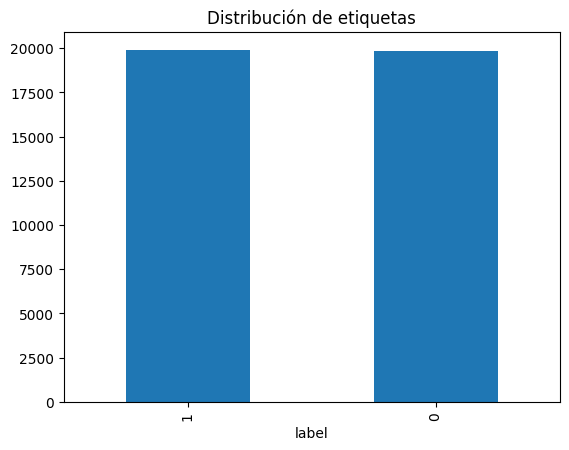

In [13]:
imdb_df.label.value_counts().plot(kind='bar', title='Distribución de etiquetas')

In [14]:
imdb_df.columns

Index(['text', 'label'], dtype='object')

# Análisis del Problema

### Objetivo

Desarrollar un método basado en redes neuronales recurrentes que permita
clasificar con precisión las reseñas de películas en IMDb en una de las dos
categorías: positiva o negativa.

### Actividades por realizar

1. **Preprocesamiento de las reseñas:** Construir un pipeline que permita limpiar y
tokenizar las reseñas de texto, convirtiéndolas en secuencias numéricas
utilizando embeddings (por ejemplo, Word2Vec o GloVe).

2. **Desarrollo de la arquitectura de red neuronal recurrente:** Implementar una
RNN (por ejemplo, LSTM o GRU) para la clasificación de las reseñas en dos
categorías. La arquitectura de la red es de libre elección, pero se sugiere incluir
capas de embedding, capas recurrentes y una capa densa de salida con
activación sigmoide. Justificar la elección de cada capa del modelo.

3. **Entrenamiento y evaluación del modelo:** Dividir el dataset en conjuntos de
entrenamiento, validación y prueba. Entrenar el modelo utilizando el conjunto de
entrenamiento y evaluar su rendimiento con el conjunto de prueba, reportando

# Preprocesamiento de  las reseñas

Vamos a utilizar Word2Vec como transformer y generar posteriormente un pipeline modular para trabajar con él.


In [15]:
!pip uninstall -y numpy
!pip install numpy==1.26.4 --force-reinstall

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [16]:
!pip install gensim --force-reinstall

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Att

In [17]:
import gensim.models.word2vec as w2v
import multiprocessing

In [18]:
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Clase de Preprocesamiento

In [19]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess(self, text):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(t) for t in tokens if t not in self.stop_words]
        return tokens


# Tokenización y Vocabulario

In [20]:
class VocabBuilder():
    def __init__(self, min_freq=1):
        self.vocab = {'<PAD>': 0, '<UNK>': 1}

    def build(self, tokenized_texts):
        for tokens in tokenized_texts:
            for token in tokens:
                if token not in self.vocab:
                    self.vocab[token] = len(self.vocab)
        return self.vocab

    def encode(self, tokens, max_len):
        ids = [self.vocab.get(t, self.vocab['<UNK>']) for t in tokens]
        ids = ids[:max_len] + [self.vocab['<PAD>']] * max(0, max_len - len(ids))
        return ids

# Clase para crear los tensores para el dataset

In [21]:
class PrepareDataset(Dataset):
    def __init__(self, encoded_reviews, labels):
        self.X = torch.tensor(encoded_reviews, dtype=torch.long)
        self.y = torch.tensor(labels.tolist(), dtype=torch.float)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Crear la matriz de Embeddings

In [22]:
def build_embedding_matrix(w2v_model, vocab, embedding_dim):
    matrix = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim))
    matrix[vocab['<PAD>']] = np.zeros(embedding_dim)
    for word, idx in vocab.items():
        if word in w2v_model:
            matrix[idx] = w2v_model[word]
    return torch.tensor(matrix, dtype=torch.float)


# Arquitectura RNN

### Justificación

En esta clase creamos una arquitectura RNN configurable. La arquitectura tiene las siguientes componentes:

1. Parámetros de la red:

*  **Un número de capas** que es configurable, pero por defecto tenemos una capa.
*  **La direccionalidad de la red** también va a ser configurable. Por defecto es unidireccional. Esto nos va a servir para comparar qué conviene más para el análisis de sentimiento con RNN.

* **El tipo de red RNN** es configurable y puede ser 'ltsm' o 'gru'. Esta configuración es configurable. Por defecto se utilizará ltsm y lo podremos cambiar dentro de las ablaciones para ver cuál nos conviene más para este caso de uso.

2. Tipos de capas:

Explicamos aquí los tipos de capas de la red, ya que van a ser configurables dentro de las ablaciones.

*   **Una capa de embedding** la cual es la entrada al modelo y en la cual podemos recibir por parámetro, ya que podemos utilizar un modelo pre-entrenado y sus embeddings en un tamaño específico
*   **Una serie de capas ocultas** cuya dimensión es configurable y esto nos servirá para configurarlo en nuestras ablaciones. El tipo de red y las dimensiones dependerán de los parámetros de la ablación en concreto.
* **Una capa de salida sigmoide** dado que el problema es de clasificación binaria, esta capa nos permitirá generar la respuesta (Positiva/Negativa)






---


| Acrónimo | Significado            |
| -------- | ---------------------- |
| **LSTM** | Long Short-Term Memory |
| **GRU**  | Gated Recurrent Unit   |




In [23]:
class SentimentRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers=1, bidirectional=False, rnn_type='lstm', dropout=0.3):
        super().__init__()
        num_embeddings, emb_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        rnn_cls = nn.LSTM if rnn_type == 'lstm' else nn.GRU
        self.rnn = rnn_cls(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )

        direction_factor = 2 if bidirectional else 1
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * direction_factor, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.rnn(embedded)
        if isinstance(hidden, tuple):  # LSTM
            hidden = hidden[0]

        if hidden.dim() == 3:
            if self.rnn.bidirectional and hidden.shape[0] >= 2:
                last_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
            else:
                last_hidden = hidden[-1]
        else:
            last_hidden = hidden.squeeze(0)

        return self.sigmoid(self.fc(self.dropout(last_hidden))).squeeze(1)


    def extra_repr(self):
        return f"RNN(hidden_dim={self.rnn.hidden_size}, bidirectional={self.rnn.bidirectional})"



# Clase que representa el Pipeline para Análisis de Sentimiento

Vamos a utilizar Optuna para encontrar los mejores hiperparámetros para la red y el modelo. Por otra parte, crearemos una clase que represente el pipeline, de tal manera que podemos cargar flexiblemente el modelo preentrenado y podamos configurar los modelos y arquitecturas para hacer las ablaciones y optimizaciones en cada caso.

In [24]:
!pip install optuna

In [25]:
import optuna

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [27]:
import matplotlib.pyplot as plt

In [28]:
import matplotlib.ticker as mtick

In [29]:
from tqdm import tqdm

In [30]:
import nltk

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

In [37]:
class SentimentPipeline:
    def __init__(self, w2v_model, embedding_dim=300, max_len=50, search_space=None, default_archs=None, default_hparams=None):
      self.preprocessor = TextPreprocessor()
      self.tokenizer = VocabBuilder()
      self.max_len = max_len
      self.embedding_dim = embedding_dim
      self.w2v = w2v_model
      self.model = None
      self.vocab = None
      self.search_space = search_space
      self.default_archs = default_archs
      self.default_hparams = default_hparams
      self.study = None
      self.best_params = None
      self.best_score = None
      self.best_model = None
      self.results = []
      self.best_result = None

        # Espacio de búsqueda de hiperparámetros (por defecto)
      self.search_space = search_space or {
          "hidden_dim": (32, 128),
          "lr": (1e-4, 1e-2),
          "freeze": [True, False]
      }

      # Arquitecturas por defecto para ablación
      self.default_archs = default_archs or [
          {"rnn_type": "gru", "num_layers": 1, "bidirectional": False},
          {"rnn_type": "gru", "num_layers": 2, "bidirectional": True},
          {"rnn_type": "lstm", "num_layers": 1, "bidirectional": False}
      ]

      # Hiperparámetros fijos por defecto
      self.default_hparams = default_hparams or {
          "n_trials": 5,
          "epochs": 3,
          "batch_size": 4
      }
      return None

    def preprocess_and_tokenize(self, df, build_vocab=True):
        df['tokens'] = df['text'].apply(self.preprocessor.preprocess)
        if build_vocab:
            self.vocab = self.tokenizer.build(df['tokens'])
        df['encoded'] = df['tokens'].apply(lambda x: self.tokenizer.encode(x, self.max_len))
        return df

    def create_dataset(self, df):
      return PrepareDataset(df['encoded'].tolist(), df['label'])

    def train_test_split(self, df, test_size=0.2):
      return train_test_split(df, test_size=test_size, stratify=df['label'], random_state=42)



    def evaluate(self, dataset, device=None):
        device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Evaluating on device: {device}")
        dataloader = DataLoader(dataset, batch_size=2)
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = self.model(X_batch)
                predicted = (preds >= 0.5).float()
                all_preds.extend(predicted.tolist())
                all_labels.extend(y_batch.tolist())

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds)
        rec = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)

        print(f"Accuracy:  {acc:.2f}")
        print(f"Precision: {prec:.2f}")
        print(f"Recall:    {rec:.2f}")
        print(f"F1-score:  {f1:.2f}")

        return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

    def train(self, dataset, hidden_dim=64, lr=0.001, freeze=True, epochs=3,
        num_layers=1, bidirectional=False, rnn_type='lstm',
        batch_size=4, dropout=0.3, device=None):



      device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"Training on device: {device}")

      dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

      embedding_matrix = build_embedding_matrix(self.w2v, self.vocab, self.embedding_dim)

      # Asegurar compatibilidad bidireccional
      if bidirectional and hidden_dim % 2 != 0:
          print(f"Adjusted hidden_dim from {hidden_dim} to {hidden_dim + 1} for bidirectionality.")
          hidden_dim += 1

      # Crear el modelo con dropout configurable
      self.model = SentimentRNN(
          embedding_matrix,
          hidden_dim=hidden_dim,
          num_layers=num_layers,
          bidirectional=bidirectional,
          rnn_type=rnn_type,
          dropout=dropout if num_layers > 1 else 0.0
      ).to(device)

      self.model.embedding.weight.requires_grad = not freeze

      optimizer = optim.Adam(self.model.parameters(), lr=lr)
      criterion = nn.BCELoss()

      self.model.train()
      for epoch in range(epochs):
          total_loss = 0
          correct = 0
          total = 0

          for X_batch, y_batch in dataloader:
              X_batch, y_batch = X_batch.to(device), y_batch.to(device)
              optimizer.zero_grad()
              preds = self.model(X_batch)
              loss = criterion(preds, y_batch)
              loss.backward()
              optimizer.step()

              total_loss += loss.item()
              predicted = (preds >= 0.5).float()
              correct += (predicted == y_batch).sum().item()
              total += y_batch.size(0)

          acc = correct / total
          print(f"Epoch {epoch + 1} | Loss: {total_loss:.4f} | Accuracy: {acc:.2f}")



    def evaluate_model(self, model, dataset, batch_size):
      dataloader = DataLoader(dataset, batch_size=batch_size)
      model.eval()
      all_preds, all_labels = [], []
      with torch.no_grad():
          for X_batch, y_batch in dataloader:
              preds = model(X_batch)
              predicted = (preds >= 0.5).float()
              all_preds.extend(predicted.tolist())
              all_labels.extend(y_batch.tolist())
      f1 = f1_score(all_labels, all_preds)
      return f1

    def predict(self, text, device=None):
        device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Predicting on device: {device}")
        tokens = self.preprocessor.preprocess(text)
        encoded = self.tokenizer.encode(tokens, self.max_len)
        input_tensor = torch.tensor([encoded], dtype=torch.long).to(device)
        self.model.eval()
        with torch.no_grad():
            output = self.model(input_tensor)
        return "Positive" if output.item() >= 0.5 else "Negative"

    def optimize(self, df, n_trials=10):
      df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
      df_train = self.preprocess_and_tokenize(df_train, build_vocab=True)
      df_val = self.preprocess_and_tokenize(df_val, build_vocab=False)

      train_dataset = self.create_dataset(df_train)
      val_dataset = self.create_dataset(df_val)

      def objective(trial):
          hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
          lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
          freeze = trial.suggest_categorical("freeze", [True, False])
          dropout = trial.suggest_float("dropout", 0.1, 0.5)
          num_layers = trial.suggest_int("num_layers", 1, 3)
          bidirectional = trial.suggest_categorical("bidirectional", [True, False])
          rnn_type = trial.suggest_categorical("rnn_type", ["gru", "lstm"])

          self.train(
              train_dataset,
              hidden_dim=hidden_dim,
              lr=lr,
              freeze=freeze,
              dropout=dropout,
              num_layers=num_layers,
              bidirectional=bidirectional,
              rnn_type=rnn_type,
              epochs=3,
              batch_size=4
          )

          metrics = self.evaluate(val_dataset)
          return metrics["f1"]  # Optimizamos F1

      study = optuna.create_study(direction="maximize")
      study.optimize(objective, n_trials=n_trials)

      print(" Mejores hiperparámetros encontrados:")
      print(study.best_params)

      # Guardar configuración completa
      self.best_config = {
          **study.best_params,
          "batch_size": 4,
          "epochs": 3
      }
      self.best_model = self.model
      return study.best_params



    def run_ablation(self, df, configs, visualize=False, parallel=False):
        import concurrent.futures
        from functools import partial

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        df_train, df_val = self.train_test_split(df)
        df_train = self.preprocess_and_tokenize(df_train, build_vocab=True)
        df_val = self.preprocess_and_tokenize(df_val, build_vocab=False)
        train_dataset = self.create_dataset(df_train)
        val_dataset = self.create_dataset(df_val)

        def run_config(config):
            print(f"\nProbando Configuración: {config}")
            self.train(
                train_dataset,
                hidden_dim=self.search_space.get("hidden_dim", 64),
                lr=self.default_hparams.get("lr", 0.001),
                freeze=self.default_hparams.get("freeze", True),
                epochs=self.default_hparams.get("epochs", 5),
                num_layers=config.get("num_layers", 1),
                bidirectional=config.get("bidirectional", False),
                rnn_type=config.get("rnn_type", "lstm"),
                dropout=config.get("dropout", 0.3),
                batch_size=self.default_hparams.get("batch_size", 4),
                device=device
            )
            metrics = self.evaluate(val_dataset, device=device)
            return {"config": config, **metrics}

        if parallel:
            with concurrent.futures.ProcessPoolExecutor() as executor:
                results = list(tqdm(executor.map(partial(run_config), configs), total=len(configs), desc="Corriendo ablación en paralelo"))
        else:
            results = [run_config(config) for config in tqdm(configs, desc="Corriendo Ablación")]

        results = sorted(results, key=lambda r: r['f1'], reverse=True)

        if visualize:
            self.visualize_results(results)

        return results


    def visualize_results(self, results):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick

        if not results:
            print("No hay resultados para visualizar.")
            return

        df = pd.DataFrame(results)
        #df['label'] = df['architecture'].apply(lambda x: f"{x['rnn_type']}-{x['num_layers']}x{'bi' if x['bidirectional'] else 'uni'}")
        df = df.sort_values(by="f1", ascending=False)

        plt.figure(figsize=(10, 5))
        bars = plt.bar(df['label'], df['f1'], color='skyblue')
        plt.title("F1-score por arquitectura optimizada")
        plt.ylabel("F1-score")
        plt.ylim(0, 1)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xticks(rotation=45)

        for bar, f1 in zip(bars, df['f1']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{f1:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def optimize_from_ablation(self, df, ablated_archs, n_trials=5, epochs=3, save_path=None, batch_size=2):
        import time
        if not hasattr(self.w2v, '__contains__'):
            raise TypeError("El modelo de embeddings proporcionado no es válido. Asegúrate de usar api.load(...) y no el módulo gensim.downloader.")

        df_train, df_val = self.train_test_split(df)
        df_train = self.preprocess_and_tokenize(df_train, build_vocab=True)
        df_val = self.preprocess_and_tokenize(df_val, build_vocab=False)
        train_dataset = self.create_dataset(df_train)
        val_dataset = self.create_dataset(df_val)

        all_results = []

        for arch in tqdm(ablated_archs, desc="Architectures"):
            print(f"\nOptimizing for architecture: {arch}")

            def objective(trial):
                hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
                lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
                freeze = trial.suggest_categorical("freeze", [True, False])

                model = self.train_model(
                    train_dataset,
                    hidden_dim=hidden_dim,
                    lr=lr,
                    freeze=freeze,
                    epochs=epochs,
                    num_layers=arch["num_layers"],
                    bidirectional=arch["bidirectional"],
                    rnn_type=arch["rnn_type"],
                    dropout=arch["dropout"],
                    batch_size=batch_size
                )
                f1 = self.evaluate_model(model, val_dataset, batch_size=batch_size)
                return f1

            start_time = time.time()
            study = optuna.create_study(direction="maximize")
            study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
            elapsed_time = time.time() - start_time

            best_params = study.best_params
            best_score = study.best_value

            result = {
               # "architecture": arch,
                **best_params,
                "f1": best_score,
                "time_sec": round(elapsed_time, 2)
            }
            all_results.append(result)
            print(f"Mejor resultado para la arquitectura {arch}: {result}")

        if save_path:
            pd.DataFrame(all_results).to_csv(save_path, index=False)
            print(f"Resultados guardados en: {save_path}")

        return all_results

    def visualize_ablation_results(self,results):

      if not results:
          print("No hay resultados para visualizar.")
          return

      df = pd.DataFrame(results)
      df['label'] = df['config'].apply(lambda cfg: f"{cfg.get('rnn_type', '')}-{cfg.get('num_layers', '')}x{'bi' if cfg.get('bidirectional', False) else 'uni'}")

      df = df.sort_values(by="f1", ascending=False)

      plt.figure(figsize=(10, 5))
      bars = plt.bar(df['label'], df['f1'], color='skyblue')
      plt.title("F1-score por configuración (ablation)")
      plt.ylabel("F1-score")
      plt.ylim(0, 1)
      plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
      plt.xticks(rotation=45)

      for bar, f1 in zip(bars, df['f1']):
          plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{f1:.2f}", ha='center', va='bottom')

      plt.tight_layout()
      plt.show()

    def run_and_compare(self, df, configs, epochs=3, batch_size=4):
        """
        Ejecuta el pipeline para cada configuración y guarda métricas.
        """
        df_train, df_val = self.train_test_split(df)
        df_train = self.preprocess_and_tokenize(df_train, build_vocab=True)
        df_val = self.preprocess_and_tokenize(df_val, build_vocab=False)
        train_dataset = self.create_dataset(df_train)
        val_dataset = self.create_dataset(df_val)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Running on device: {device}")

        results = []
        best_score = -1
        best_model = None
        best_config = None

        for cfg in configs:
            print(f"\nProbando configuración: {cfg}")
            hidden_dim = cfg.get("hidden_dim", 64)

            if cfg.get("bidirectional") and hidden_dim % 2 != 0:
                print(f"hidden_dim ajustado de {hidden_dim} a {hidden_dim + 1}")
                hidden_dim += 1

            self.train(
                train_dataset,
                hidden_dim=hidden_dim,
                lr=cfg.get("lr", 0.001),
                freeze=cfg.get("freeze", True),
                epochs=epochs,
                num_layers=cfg.get("num_layers", 1),
                bidirectional=cfg.get("bidirectional", False),
                rnn_type=cfg.get("rnn_type", "lstm"),
                dropout=cfg.get("dropout", 0.3),
                batch_size=batch_size,
                device=device
            )

            metrics = self.evaluate(val_dataset, device=device)
            metrics["config"] = cfg
            results.append(metrics)

            if metrics["f1"] > best_score:
                best_score = metrics["f1"]
                best_model = self.model
                best_config = cfg

        self.plot_comparison(results)

        return {
            "results": results,
            "best_model": best_model,
            "best_config": best_config
        }

    def evaluate_with_confusion(self, dataset, device=None):
      device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"Evaluating on device: {device}")

      dataloader = DataLoader(dataset, batch_size=2)
      self.model.eval()
      all_preds = []
      all_labels = []

      with torch.no_grad():
          for X_batch, y_batch in dataloader:
              X_batch, y_batch = X_batch.to(device), y_batch.to(device)
              preds = self.model(X_batch)
              predicted = (preds >= 0.5).float()
              all_preds.extend(predicted.cpu().numpy())
              all_labels.extend(y_batch.cpu().numpy())

      print(classification_report(all_labels, all_preds))
      cm = confusion_matrix(all_labels, all_preds)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot()

    def plot_comparison(self, results):
        import matplotlib.pyplot as plt
        import pandas as pd

        if not results:
            print("No hay resultados para graficar.")
            return

        # Convertir resultados a DataFrame
        df = pd.DataFrame(results)
        df["config_str"] = df["config"].apply(
            lambda cfg: f"{cfg['rnn_type']}-{cfg['num_layers']}x{'bi' if cfg['bidirectional'] else 'uni'}"
        )

        metrics = ["accuracy", "f1", "recall", "precision"]
        x_labels = df["config_str"]
        x = range(len(x_labels))
        width = 0.2

        plt.figure(figsize=(12, 6))
        for i, metric in enumerate(metrics):
            values = df[metric]
            bar_positions = [p + i * width for p in x]
            plt.bar(bar_positions, values, width=width, label=metric)

        plt.xticks([p + width * 1.5 for p in x], x_labels, rotation=45)
        plt.ylabel("Score")
        plt.ylim(0, 1.05)
        plt.title("Comparación de métricas por arquitectura")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Guardar como atributo del pipeline
        self.last_comparison_df = df




# Entrenamiento del modelo con el Pipeline

In [34]:
df = imdb_df.copy()

Bajamos el modelo pre-entrenado de glove para agregar nuestro entrenamiento posteriormente.

In [35]:
import gensim.downloader as api
w2v= api.load("glove-wiki-gigaword-100")  # 130 MB

Utilizamos el modelo Glove para utilizar con 100 dimensiones de embedding (esto va en nuestros parámetros del pipeline). Dado que encontrar los mejores parámetros con optuna nos está tardando demasiado, vamos hacer dos "trials". Con estos esperamos optimizar los hiperparámetros y Hemos equipado al pipeline con un método para correr la ablación, el cual estaremos utilizando más adelante.

In [38]:
# 1. Inicializar pipeline
pipeline = SentimentPipeline(w2v_model=w2v, embedding_dim=100, max_len=50)

# 2. Buscar mejores hiperparámetros
best_params = pipeline.optimize(df, n_trials=2)



[I 2025-05-13 18:57:08,861] A new study created in memory with name: no-name-d32447c2-d725-4197-834f-4a392dbdae53


Training on device: cuda
Epoch 1 | Loss: 3466.9128 | Accuracy: 0.79
Epoch 2 | Loss: 1733.8123 | Accuracy: 0.92
Epoch 3 | Loss: 717.7205 | Accuracy: 0.97
Evaluating on device: cuda


[I 2025-05-13 19:00:11,722] Trial 0 finished with value: 0.8163365727641776 and parameters: {'hidden_dim': 34, 'lr': 0.0014378372074395109, 'freeze': False, 'dropout': 0.11370806346918037, 'num_layers': 2, 'bidirectional': True, 'rnn_type': 'lstm'}. Best is trial 0 with value: 0.8163365727641776.


Accuracy:  0.81
Precision: 0.79
Recall:    0.84
F1-score:  0.82
Training on device: cuda
Epoch 1 | Loss: 4073.4347 | Accuracy: 0.75
Epoch 2 | Loss: 2280.8474 | Accuracy: 0.88
Epoch 3 | Loss: 1189.2287 | Accuracy: 0.95
Evaluating on device: cuda


[I 2025-05-13 19:02:52,104] Trial 1 finished with value: 0.7888467076842519 and parameters: {'hidden_dim': 84, 'lr': 0.0010280292129417384, 'freeze': False, 'dropout': 0.2670401734930037, 'num_layers': 2, 'bidirectional': False, 'rnn_type': 'lstm'}. Best is trial 0 with value: 0.8163365727641776.


Accuracy:  0.80
Precision: 0.82
Recall:    0.76
F1-score:  0.79
 Mejores hiperparámetros encontrados:
{'hidden_dim': 34, 'lr': 0.0014378372074395109, 'freeze': False, 'dropout': 0.11370806346918037, 'num_layers': 2, 'bidirectional': True, 'rnn_type': 'lstm'}


Aunque en cada ejecución hemos visto que los "trials" ejecutan parámetros diferentes, quisimos guardar esta ejecución que funcionó particularmente bien al primer intento:


```
[I 2025-05-13 11:37:25,905] A new study created in memory with name: no-name-4fe41a2d-b69c-41e6-9b1d-30361e162e6c
Training on device: cuda
Epoch 1 | Loss: 3375.3602 | Accuracy: 0.80
Epoch 2 | Loss: 1681.8996 | Accuracy: 0.92
Epoch 3 | Loss: 544.4200 | Accuracy: 0.98
Evaluating on device: cuda
[I 2025-05-13 11:40:25,239] Trial 0 finished with value: 0.8155219439623109 and parameters: {'hidden_dim': 113, 'lr': 0.0011521998363690483, 'freeze': False, 'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True}. Best is trial 0 with value: 0.8155219439623109.
Accuracy:  0.81
Precision: 0.81
Recall:    0.83
F1-score:  0.82
```



In [39]:
best_params

{'hidden_dim': 34,
 'lr': 0.0014378372074395109,
 'freeze': False,
 'dropout': 0.11370806346918037,
 'num_layers': 2,
 'bidirectional': True,
 'rnn_type': 'lstm'}

En estas celdas entrenamos el modelo con los mejores parámetros encontrados.

In [98]:
# 3. Preprocesar, codificar y crear dataset
df = pipeline.preprocess_and_tokenize(df)
dataset = pipeline.create_dataset(df)

# 4. Entrenar modelo con mejores parámetros
pipeline.train(
    dataset,
    hidden_dim=best_params["hidden_dim"],
    lr=best_params["lr"],
    num_layers=best_params["num_layers"],
    bidirectional=best_params["bidirectional"],
    rnn_type=best_params["rnn_type"],
    freeze=best_params["freeze"],
    dropout=best_params["dropout"],
    epochs=5
)

# 5. Evaluar el modelo
pipeline.evaluate(dataset)

# 6. Probar con nuevo texto
print(pipeline.predict("This was a wonderful film with great characters"))
print(pipeline.predict("Awful movie, I couldn't even finish it"))

Training on device: cuda
Epoch 1 | Loss: 4295.3270 | Accuracy: 0.80
Epoch 2 | Loss: 2273.9242 | Accuracy: 0.91
Epoch 3 | Loss: 1062.6027 | Accuracy: 0.96
Epoch 4 | Loss: 421.8243 | Accuracy: 0.99
Epoch 5 | Loss: 151.5001 | Accuracy: 1.00
Evaluating on device: cuda
Accuracy:  1.00
Precision: 1.00
Recall:    1.00
F1-score:  1.00
Predicting on device: cuda
Positive
Predicting on device: cuda
Negative


Vemos que con los mejores hiper parámetros encontrados por optuna hemos logrado unas métricas buenas. Sin embargo vamos a intentar optimizar por medio de la ablación. Para esto vamos a generar una función para optimizar con respecto a esta ablación.

Guardamos el mejor modelo aquí para poder utilizarlo después si

In [99]:
mejor_modelo = pipeline.model

Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19815
         1.0       1.00      1.00      1.00     19908

    accuracy                           1.00     39723
   macro avg       1.00      1.00      1.00     39723
weighted avg       1.00      1.00      1.00     39723



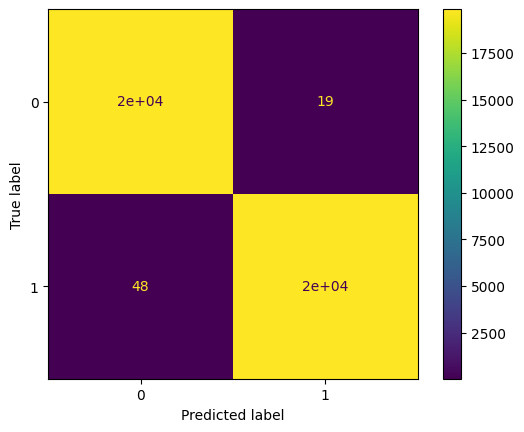

In [42]:
pipeline.evaluate_with_confusion(dataset)

Vemos que este modelo tiene un muy buen rendimiento sobre el dataset. Podemos utilizar este modelo para predecir cualquier nuevo texto para clasificarlo como Positivo o Negativo.

# Ablaciones - Utilización del pipeline

# Arquitectura 1 - GRU - 1 layer - unidirectional - hidden dimmensions

Vamos a crear una configuración de arquitectura. Pasamos el parámetro de dropout, pero no debe tener efecto en el entrenamiento, ya que la arquitectura tiene sólo una capa.

In [43]:
search_space = {
    "hidden_dim": best_params['hidden_dim'],
    "lr": best_params['lr'],
    "freeze": best_params['freeze']
}

ablated_archs = [
        {"rnn_type": "gru", "num_layers": 1, "bidirectional": False ,"dropout": 0.5},
    ]

pipeline = SentimentPipeline(
    w2v_model=w2v,
    embedding_dim=100,
    search_space=search_space,
    default_archs=ablated_archs,
    default_hparams={"n_trials": 2, "epochs": 5, "batch_size": 4}
)

results = pipeline.run_ablation(df,configs=ablated_archs)  # usa todo lo parametrizado


Corriendo Ablación:   0%|          | 0/1 [00:00<?, ?it/s]


Probando Configuración: {'rnn_type': 'gru', 'num_layers': 1, 'bidirectional': False, 'dropout': 0.5}
Training on device: cuda
Epoch 1 | Loss: 3915.9107 | Accuracy: 0.75
Epoch 2 | Loss: 3306.4288 | Accuracy: 0.81
Epoch 3 | Loss: 3050.6584 | Accuracy: 0.82
Epoch 4 | Loss: 2836.8470 | Accuracy: 0.84
Epoch 5 | Loss: 2635.7685 | Accuracy: 0.85
Evaluating on device: cuda


Corriendo Ablación: 100%|██████████| 1/1 [01:34<00:00, 94.67s/it]

Accuracy:  0.81
Precision: 0.78
Recall:    0.86
F1-score:  0.82


In [44]:
model1 = pipeline.model

In [45]:
model1

SentimentRNN(
  RNN(hidden_dim=34, bidirectional=False)
  (embedding): Embedding(128180, 100)
  (rnn): GRU(100, 34, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=34, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [46]:
print("\nResumen de resultados:")
for r in results:
    print(r)


Resumen de resultados:
{'config': {'rnn_type': 'gru', 'num_layers': 1, 'bidirectional': False, 'dropout': 0.5}, 'accuracy': 0.81019509125236, 'precision': 0.7813921747042766, 'recall': 0.8626318432948267, 'f1': 0.8200047744091669}


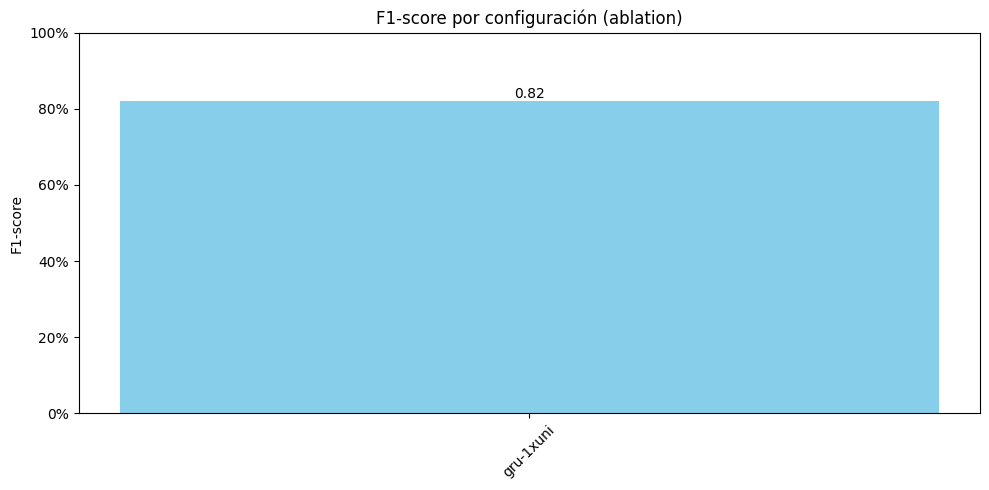

In [47]:
pipeline.visualize_ablation_results(results)

In [48]:
#pipeline.model = pipeline.best_model  # o el que quieras evaluar

df_val = pipeline.preprocess_and_tokenize(df, build_vocab=False)
val_dataset = pipeline.create_dataset(df_val)



Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       0.89      0.82      0.86     19815
         1.0       0.84      0.90      0.87     19908

    accuracy                           0.86     39723
   macro avg       0.87      0.86      0.86     39723
weighted avg       0.87      0.86      0.86     39723



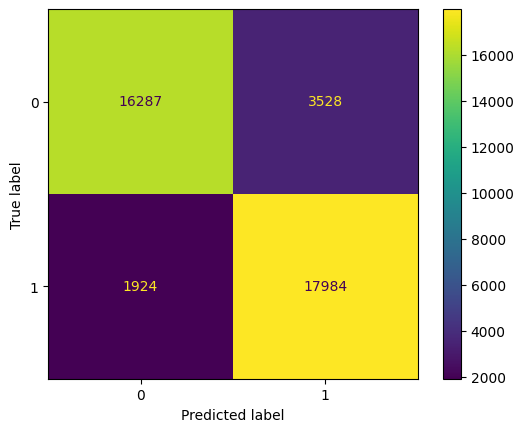

In [49]:
pipeline.evaluate_with_confusion(val_dataset)

In [50]:
pipeline.best_model = model1

# Arquitectura 2 - GRU - 2 layers - Bidirectional  (68 hidden- units)

In [60]:
ablated_archs = [
        {"rnn_type": "gru", "num_layers": 2, "bidirectional": True,"dropout": 0.3},
    ]


En esta ablación colocamos las dimensiones manualmente dado que hubo problemas al tener un número de unidades impar. Seleccionamos 68, dado que fue uno de los valores que encontramos en una de las iteraciones de optimización anteriormente. Cabe anotar que **cada vez que se corren las iteraciones de optimización, las unidades pueden cambiar, por lo que estos parámetros no son fijos** seleccionamos 68 sólo para colocar un valor que pueda funcionar en la ablación.

In [61]:
search_space = {
    "hidden_dim": 68,
    #"hidden_dim": best_params['hidden_dim'],
    "lr": best_params['lr'],
    "freeze": best_params['freeze']
}

In [53]:
pipeline = SentimentPipeline(
    w2v_model=w2v,
    embedding_dim=100,
    search_space=search_space,
    default_archs=ablated_archs,
    default_hparams={"n_trials": 2, "epochs": 5, "batch_size": 4}
)

results_2 = pipeline.run_ablation(df,configs=ablated_archs)


Corriendo Ablación:   0%|          | 0/1 [00:00<?, ?it/s]


Probando Configuración: {'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True, 'dropout': 0.3}
Training on device: cuda
Epoch 1 | Loss: 3895.6390 | Accuracy: 0.76
Epoch 2 | Loss: 3277.9461 | Accuracy: 0.81
Epoch 3 | Loss: 2913.6971 | Accuracy: 0.83
Epoch 4 | Loss: 2489.1013 | Accuracy: 0.86
Epoch 5 | Loss: 2066.4372 | Accuracy: 0.89
Evaluating on device: cuda


Corriendo Ablación: 100%|██████████| 1/1 [02:27<00:00, 147.08s/it]

Accuracy:  0.80
Precision: 0.81
Recall:    0.79
F1-score:  0.80


In [54]:
model2 = pipeline.model

In [55]:
model2

SentimentRNN(
  RNN(hidden_dim=68, bidirectional=True)
  (embedding): Embedding(128180, 100)
  (rnn): GRU(100, 68, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=136, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [56]:
print("\nResumen de resultados 3ra arquitectura:")
for r in results_2:
    print(r)


Resumen de resultados 3ra arquitectura:
{'config': {'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True, 'dropout': 0.3}, 'accuracy': 0.8013845185651353, 'precision': 0.8122077922077922, 'recall': 0.7852837769964842, 'f1': 0.7985188968335035}


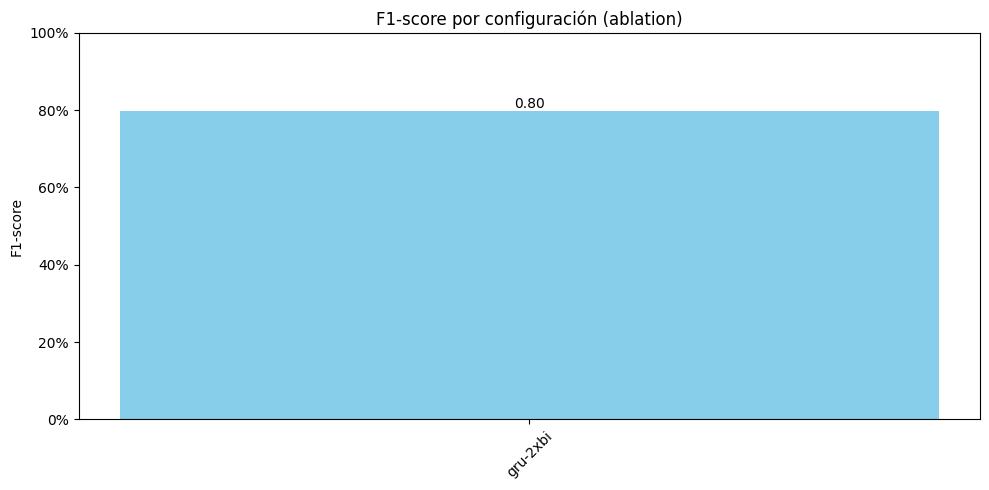

In [57]:
pipeline.visualize_ablation_results(results_2)

Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     19815
         1.0       0.93      0.89      0.91     19908

    accuracy                           0.91     39723
   macro avg       0.91      0.91      0.91     39723
weighted avg       0.91      0.91      0.91     39723



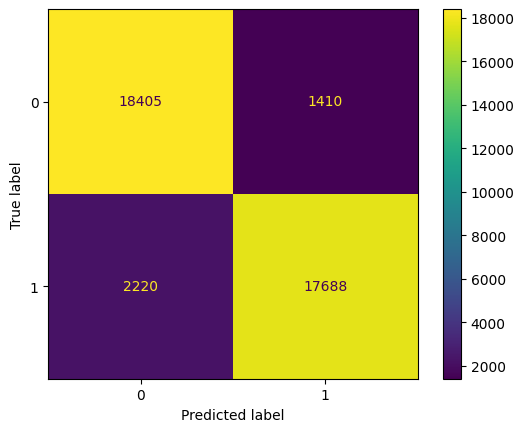

In [58]:
pipeline.evaluate_with_confusion(val_dataset)

# Arquitectura 3 : LSTM - 1 layer - Unidirectional -  Optimal Hidden Units

In [62]:
search_space = {
    "hidden_dim": best_params['hidden_dim'],
    "lr": best_params['lr'],
    "freeze": best_params['freeze']
}

In [63]:
ablated_archs = [
        {"rnn_type": "lstm", "num_layers": 1, "bidirectional": False,"dropout": 0.3},
    ]


In [64]:
pipeline = SentimentPipeline(
    w2v_model=w2v,
    embedding_dim=100,
    search_space=search_space,
    default_archs=ablated_archs,
    default_hparams={"n_trials": 2, "epochs": 5, "batch_size": 4}
)

results_3 = pipeline.run_ablation(df,configs=ablated_archs)  # usa todo lo parametrizado


Corriendo Ablación:   0%|          | 0/1 [00:00<?, ?it/s]


Probando Configuración: {'rnn_type': 'lstm', 'num_layers': 1, 'bidirectional': False, 'dropout': 0.3}
Training on device: cuda
Epoch 1 | Loss: 4463.8450 | Accuracy: 0.71
Epoch 2 | Loss: 3608.4780 | Accuracy: 0.78
Epoch 3 | Loss: 3353.7401 | Accuracy: 0.80
Epoch 4 | Loss: 3144.1335 | Accuracy: 0.82
Epoch 5 | Loss: 2946.6841 | Accuracy: 0.83
Evaluating on device: cuda


Corriendo Ablación: 100%|██████████| 1/1 [01:39<00:00, 99.67s/it]

Accuracy:  0.79
Precision: 0.76
Recall:    0.84
F1-score:  0.80


In [65]:
model3 = pipeline.model

In [66]:
model3

SentimentRNN(
  RNN(hidden_dim=34, bidirectional=False)
  (embedding): Embedding(128180, 100)
  (rnn): LSTM(100, 34, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=34, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [67]:
print("\nResumen de resultados 3ra arquitectura:")
for r in results_3:
    print(r)


Resumen de resultados 3ra arquitectura:
{'config': {'rnn_type': 'lstm', 'num_layers': 1, 'bidirectional': False, 'dropout': 0.3}, 'accuracy': 0.7899307740717433, 'precision': 0.7648271124341653, 'recall': 0.838774485183325, 'f1': 0.8000958198586657}


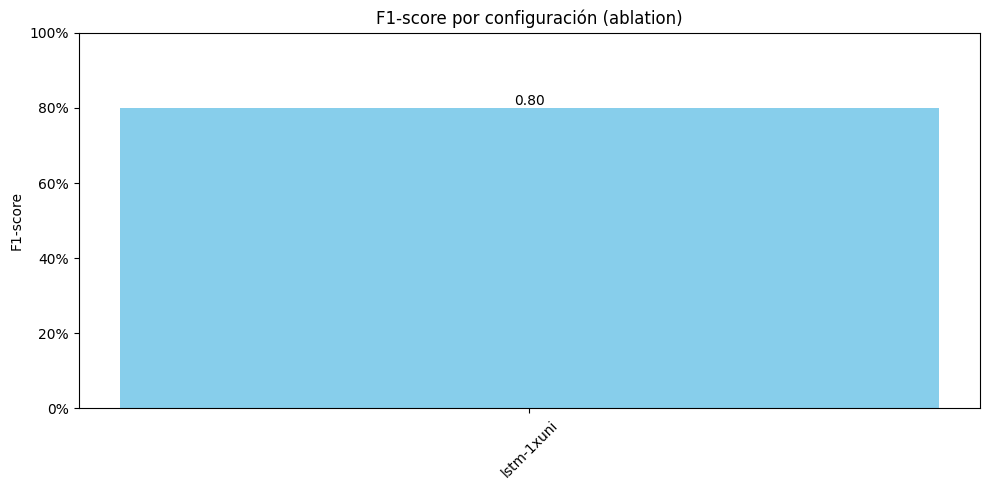

In [68]:
pipeline.visualize_ablation_results(results_3)

Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84     19815
         1.0       0.84      0.84      0.84     19908

    accuracy                           0.84     39723
   macro avg       0.84      0.84      0.84     39723
weighted avg       0.84      0.84      0.84     39723



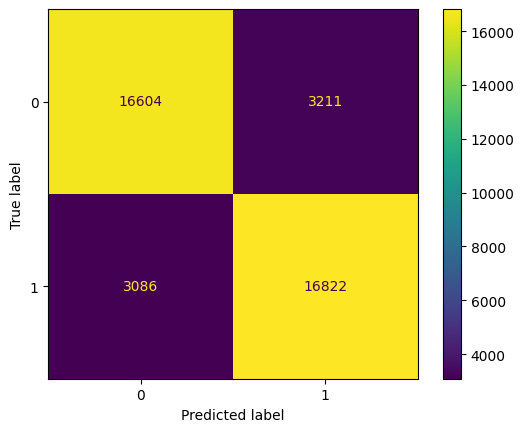

In [69]:
pipeline.evaluate_with_confusion(val_dataset)

# Arquitectura 4 - LSTM - layers-2 - Bidirectional - Optimal Hidden Units

In [70]:
search_space = {
    "hidden_dim": best_params['hidden_dim'],
    "lr": best_params['lr'],
    "freeze": best_params['freeze']
}

In [71]:
ablated_archs = [
        {"rnn_type": "lstm", "num_layers": 2, "bidirectional": True,"dropout": 0.5}
    ]

In [72]:
pipeline = SentimentPipeline(
    w2v_model=w2v,
    embedding_dim=100,
    search_space=search_space,
    default_archs=ablated_archs,
    default_hparams={"n_trials": 2, "epochs": 5, "batch_size": 4}
)

results_4 = pipeline.run_ablation(df,configs=ablated_archs)


Corriendo Ablación:   0%|          | 0/1 [00:00<?, ?it/s]


Probando Configuración: {'rnn_type': 'lstm', 'num_layers': 2, 'bidirectional': True, 'dropout': 0.5}
Training on device: cuda
Epoch 1 | Loss: 4252.6807 | Accuracy: 0.73
Epoch 2 | Loss: 3612.0360 | Accuracy: 0.79
Epoch 3 | Loss: 3348.6101 | Accuracy: 0.81
Epoch 4 | Loss: 3120.1562 | Accuracy: 0.82
Epoch 5 | Loss: 2905.4197 | Accuracy: 0.84
Evaluating on device: cuda


Corriendo Ablación: 100%|██████████| 1/1 [02:36<00:00, 156.39s/it]

Accuracy:  0.81
Precision: 0.79
Recall:    0.85
F1-score:  0.82


In [73]:
model4 = pipeline.model

In [74]:
model4

SentimentRNN(
  RNN(hidden_dim=34, bidirectional=True)
  (embedding): Embedding(128180, 100)
  (rnn): LSTM(100, 34, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=68, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [75]:
print("\nResumen de resultados 4a arquitectura:")
for r in results_4:
    print(r)


Resumen de resultados 4a arquitectura:
{'config': {'rnn_type': 'lstm', 'num_layers': 2, 'bidirectional': True, 'dropout': 0.5}, 'accuracy': 0.811453744493392, 'precision': 0.7904583723105706, 'recall': 0.8488196885986942, 'f1': 0.8186001453136352}


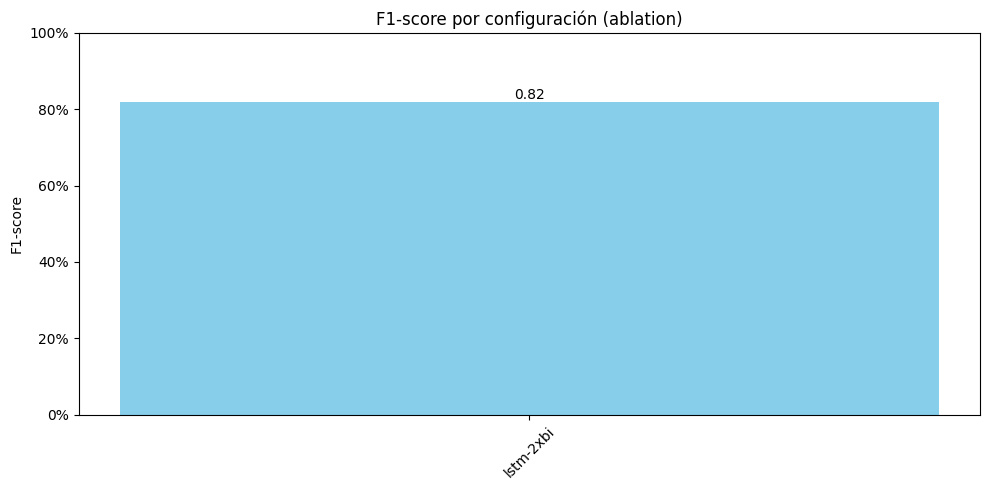

In [76]:
pipeline.visualize_ablation_results(results_4)

Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85     19815
         1.0       0.84      0.88      0.86     19908

    accuracy                           0.86     39723
   macro avg       0.86      0.86      0.86     39723
weighted avg       0.86      0.86      0.86     39723



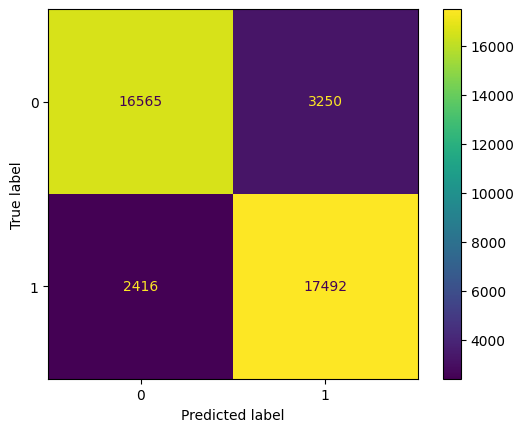

In [77]:
pipeline.evaluate_with_confusion(val_dataset)

# Arquitectura 5 - GRU- layers-2- Bidirectional - Optimal Hidden Units

In [78]:
ablated_archs = [
        {"rnn_type": "gru", "num_layers": 2, "bidirectional": True,"dropout": 0.3},
    ]

In [79]:
search_space = {
    "hidden_dim": best_params['hidden_dim'],
    "lr": best_params['lr'],
    "freeze": best_params['freeze']
}

pipeline = SentimentPipeline(
    w2v_model=w2v,
    embedding_dim=100,
    search_space=search_space,
    default_archs=ablated_archs,
    default_hparams={"n_trials": 2, "epochs": 5, "batch_size": 4}
)

results_5 = pipeline.run_ablation(df,configs=ablated_archs)  # usa todo lo parametrizado

Corriendo Ablación:   0%|          | 0/1 [00:00<?, ?it/s]


Probando Configuración: {'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True, 'dropout': 0.3}
Training on device: cuda
Epoch 1 | Loss: 3870.6594 | Accuracy: 0.76
Epoch 2 | Loss: 3296.0612 | Accuracy: 0.81
Epoch 3 | Loss: 2985.0865 | Accuracy: 0.83
Epoch 4 | Loss: 2713.9291 | Accuracy: 0.85
Epoch 5 | Loss: 2424.0472 | Accuracy: 0.87
Evaluating on device: cuda


Corriendo Ablación: 100%|██████████| 1/1 [02:25<00:00, 145.95s/it]

Accuracy:  0.80
Precision: 0.83
Recall:    0.76
F1-score:  0.80


In [80]:
model5 = pipeline.model

In [81]:
model5

SentimentRNN(
  RNN(hidden_dim=34, bidirectional=True)
  (embedding): Embedding(128180, 100)
  (rnn): GRU(100, 34, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=68, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [82]:
print("\nResumen de resultados 4a arquitectura:")
for r in results_5:
    print(r)


Resumen de resultados 4a arquitectura:
{'config': {'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True, 'dropout': 0.3}, 'accuracy': 0.8028949024543738, 'precision': 0.8291553133514986, 'recall': 0.764188849824209, 'f1': 0.7953476215368531}


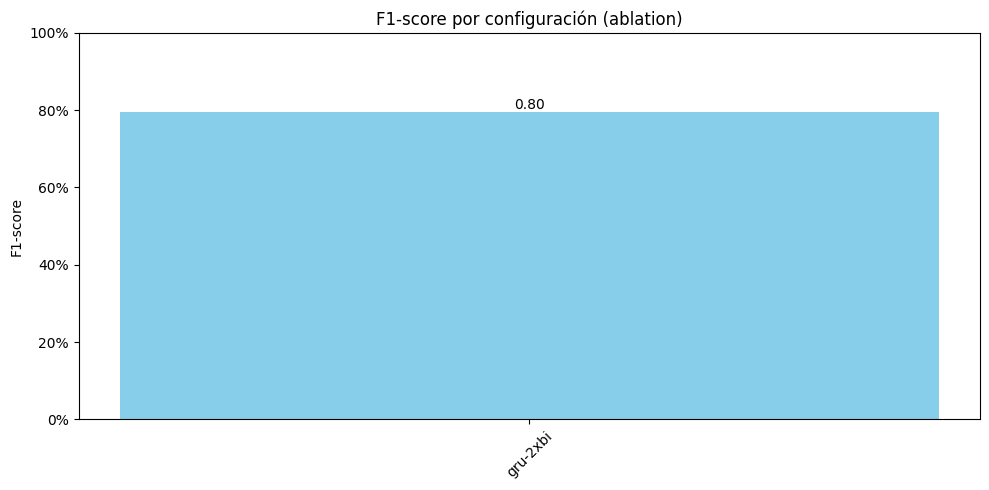

In [83]:
pipeline.visualize_ablation_results(results_5)

Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.88     19815
         1.0       0.91      0.85      0.88     19908

    accuracy                           0.88     39723
   macro avg       0.88      0.88      0.88     39723
weighted avg       0.88      0.88      0.88     39723



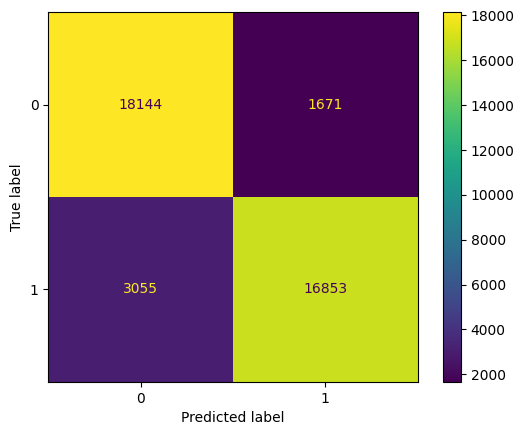

In [84]:
pipeline.evaluate_with_confusion(val_dataset)

# Comparativos de Arquitecturas y Modelos encontrados

In [85]:
data = {
    'Architecture': ['GRU-1xuni', 'GRU-2xuni', 'LSTM-1xuni', 'LSTM-2xuni', 'GRU-2xbi'],
    'F1-score': [results[0]['f1'], results_2[0]['f1'], results_3[0]['f1'], results_4[0]['f1'], results_5[0]['f1']],
    'Accuracy': [results[0]['accuracy'], results_2[0]['accuracy'], results_3[0]['accuracy'], results_4[0]['accuracy'], results_5[0]['accuracy']],
    'Precision': [results[0]['precision'], results_2[0]['precision'], results_3[0]['precision'], results_4[0]['precision'], results_5[0]['precision']],
    'Recall': [results[0]['recall'], results_2[0]['recall'], results_3[0]['recall'], results_4[0]['recall'], results_5[0]['recall']]
}

df_comparison = pd.DataFrame(data)
df_comparison = df_comparison.sort_values(by='F1-score', ascending=False)
display(df_comparison)


,Architecture,F1-score,Accuracy,Precision,Recall
0,GRU-1xuni,0.820005,0.810195,0.781392,0.862632
3,LSTM-2xuni,0.818600,0.811454,0.790458,0.848820
2,LSTM-1xuni,0.800096,0.789931,0.764827,0.838774
1,GRU-2xuni,0.798519,0.801385,0.812208,0.785284
4,GRU-2xbi,0.795348,0.802895,0.829155,0.764189


A continuación, tenemos una gráfica de comparación de resultados, tanto los de la ablación, como los hallados con el pipeline.

Vamos a tener varios subplots con las métricas de cada arquitectura.

<ipython-input-86-9e57d0225477>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
<ipython-input-86-9e57d0225477>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
<ipython-input-86-9e57d0225477>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
<ipython-input-86-9e57d0225477>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')


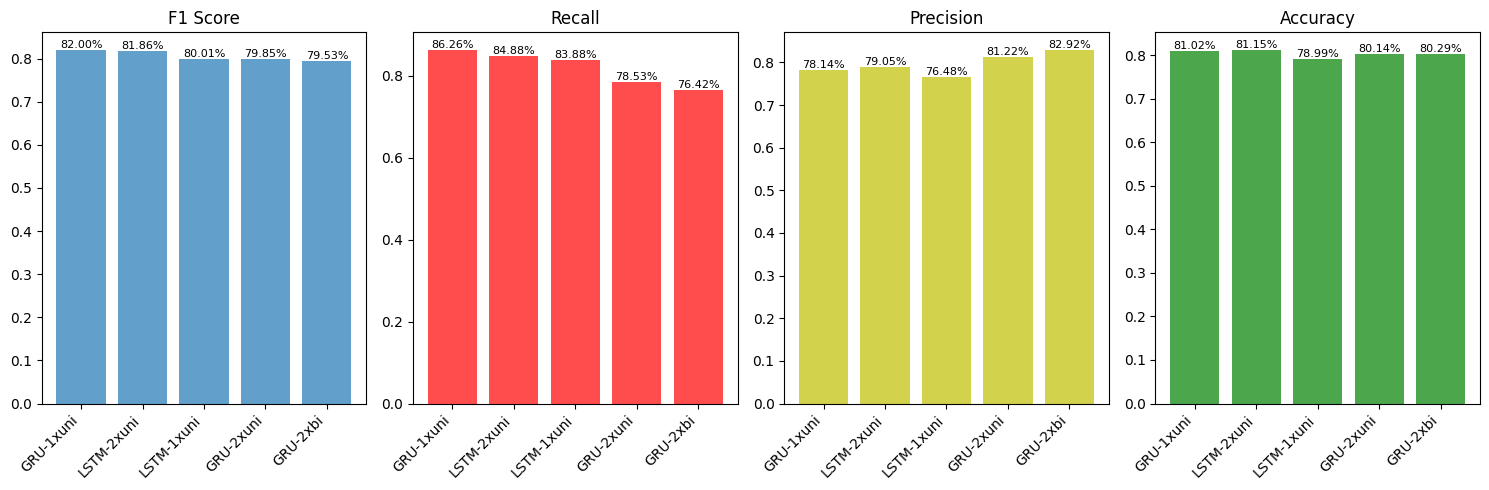

<Figure size 640x480 with 0 Axes>

In [86]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))


# Plot bar charts for each dataframe
axs[0].bar(df_comparison['Architecture'], df_comparison['F1-score'], alpha=0.7)
axs[0].set_title('F1 Score')
axs[0].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
axs[0].cmap = 'viridis'
for p in axs[0].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Agregar el texto con el valor
    axs[0].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)

axs[1].bar(df_comparison['Architecture'], df_comparison['Recall'], color='r', alpha=0.7)
axs[1].set_title('Recall')
axs[1].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
for p in axs[1].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Agregar el texto con el valor
    axs[1].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)


axs[2].bar(df_comparison['Architecture'], df_comparison['Precision'], color='y', alpha=0.7)
axs[2].set_title('Precision')
axs[2].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
for p in axs[2].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Agregar el texto con el valor
    axs[2].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)


axs[3].bar(df_comparison['Architecture'], df_comparison['Accuracy'], color='g', alpha=0.7)
axs[3].set_title('Accuracy')
axs[3].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
for p in axs[3].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Agregar el texto con el valor
    axs[3].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)



plt.tight_layout()


# Adjust layout and display the plot

plt.show()

plt.savefig('/content/drive/MyDrive/MasterIA/DeepLearning/Microproy2/comparison.png')

De acuerdo con los resultados, la mejor arquitectura es la GRU, con una capa oculta y Unidireccional. Esto lo vemos en el F1_score, que nos da una medida más equitativa. Hay otras métricas en las que incluso otras arquitecturas podrían ser adecuadas también, como es el caso de la arquitectura LSTM- de 2 capas ocultas y unidireccional, la cual tiene incluso un mejor Accuracy. En las celdas posteriores, vamos a utilizar el mejor modelo para entrenarlo por 6 épocas y generar la clasificación correspondiente.

# Una última prueba del Pipeline

En esta sección, hemos hecho una demostración de la comparación del pipeline directamente. Arriba quisimos hacer unos casos de ablación bastante claros, pero aquí mostramos el hecho de que podemos hacer la comparación automática de varias configuraciones si quisiéramos.

Running on device: cuda

Probando configuración: {'rnn_type': 'gru', 'num_layers': 1, 'bidirectional': False, 'hidden_dim': 64, 'lr': 0.001, 'freeze': True}
Training on device: cuda
Epoch 1 | Loss: 3905.7121 | Accuracy: 0.75
Epoch 2 | Loss: 3251.2047 | Accuracy: 0.81
Epoch 3 | Loss: 2942.3021 | Accuracy: 0.83
Evaluating on device: cuda
Accuracy:  0.81
Precision: 0.79
Recall:    0.85
F1-score:  0.82

Probando configuración: {'rnn_type': 'lstm', 'num_layers': 2, 'bidirectional': True, 'hidden_dim': 128, 'lr': 0.0005, 'dropout': 0.3, 'freeze': False}
Training on device: cuda
Epoch 1 | Loss: 3869.0640 | Accuracy: 0.76
Epoch 2 | Loss: 2442.3917 | Accuracy: 0.87
Epoch 3 | Loss: 1574.2095 | Accuracy: 0.92
Evaluating on device: cuda
Accuracy:  0.83
Precision: 0.81
Recall:    0.85
F1-score:  0.83

Probando configuración: {'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True, 'hidden_dim': 96, 'lr': 0.0008, 'dropout': 0.5, 'freeze': True}
Training on device: cuda
Epoch 1 | Loss: 3983.1966 |

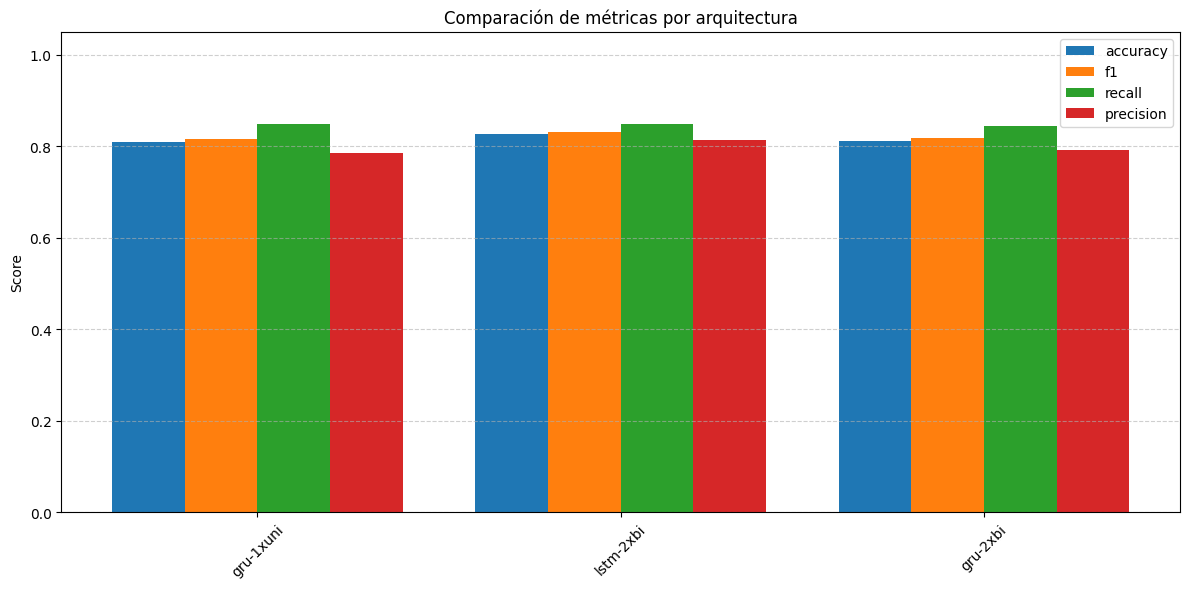

In [88]:
ablated_archs = [
    {"rnn_type": "gru", "num_layers": 1, "bidirectional": False, "hidden_dim": 64, "lr": 0.001, "freeze": True},
    {"rnn_type": "lstm", "num_layers": 2, "bidirectional": True, "hidden_dim": 128, "lr": 0.0005,"dropout":0.3, "freeze": False},
    {"rnn_type": "gru", "num_layers": 2, "bidirectional": True, "hidden_dim": 96, "lr": 0.0008, "dropout":0.5,"freeze": True}
]

summary = pipeline.run_and_compare(df, configs=ablated_archs)


Esta comparación automática nos genera un resumen de la ejecución para poder reportar nuestros resultados en esta variable llamada summary:


```
summary
```



In [89]:
summary

{'results': [{'accuracy': 0.8083071113908118,
   'precision': 0.7857308854287707,
   'recall': 0.8490708186840783,
   'f1': 0.8161738080869041,
   'config': {'rnn_type': 'gru',
    'num_layers': 1,
    'bidirectional': False,
    'hidden_dim': 64,
    'lr': 0.001,
    'freeze': True}},
  {'accuracy': 0.8271869100062933,
   'precision': 0.814413111593155,
   'recall': 0.8485685585133099,
   'f1': 0.8311400811708277,
   'config': {'rnn_type': 'lstm',
    'num_layers': 2,
    'bidirectional': True,
    'hidden_dim': 128,
    'lr': 0.0005,
    'dropout': 0.3,
    'freeze': False}},
  {'accuracy': 0.8109502831969793,
   'precision': 0.7924528301886793,
   'recall': 0.8437970868910095,
   'f1': 0.8173193870104597,
   'config': {'rnn_type': 'gru',
    'num_layers': 2,
    'bidirectional': True,
    'hidden_dim': 96,
    'lr': 0.0008,
    'dropout': 0.5,
    'freeze': True}}],
 'best_model': SentimentRNN(
   RNN(hidden_dim=128, bidirectional=True)
   (embedding): Embedding(128180, 100)
   (rnn

In [96]:
best_model = summary["best_model"]

In [97]:
best_model

SentimentRNN(
  RNN(hidden_dim=128, bidirectional=True)
  (embedding): Embedding(128180, 100)
  (rnn): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [93]:
df_results = pd.DataFrame(summary["results"])
df_results

,accuracy,precision,recall,f1,config
0,0.808307,0.785731,0.849071,0.816174,"{'rnn_type': 'gru', 'num_layers': 1, 'bidirect..."
1,0.827187,0.814413,0.848569,0.831140,"{'rnn_type': 'lstm', 'num_layers': 2, 'bidirec..."
2,0.810950,0.792453,0.843797,0.817319,"{'rnn_type': 'gru', 'num_layers': 2, 'bidirect..."


Aquí podemos comparar los resultados gráficamente entre las diferentes arquitecturas, de manera más evidente.

In [94]:
import matplotlib.cm as cm
from matplotlib.patches import Patch

<ipython-input-95-d0e751fbc4c6>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_configs)(np.arange(num_configs))


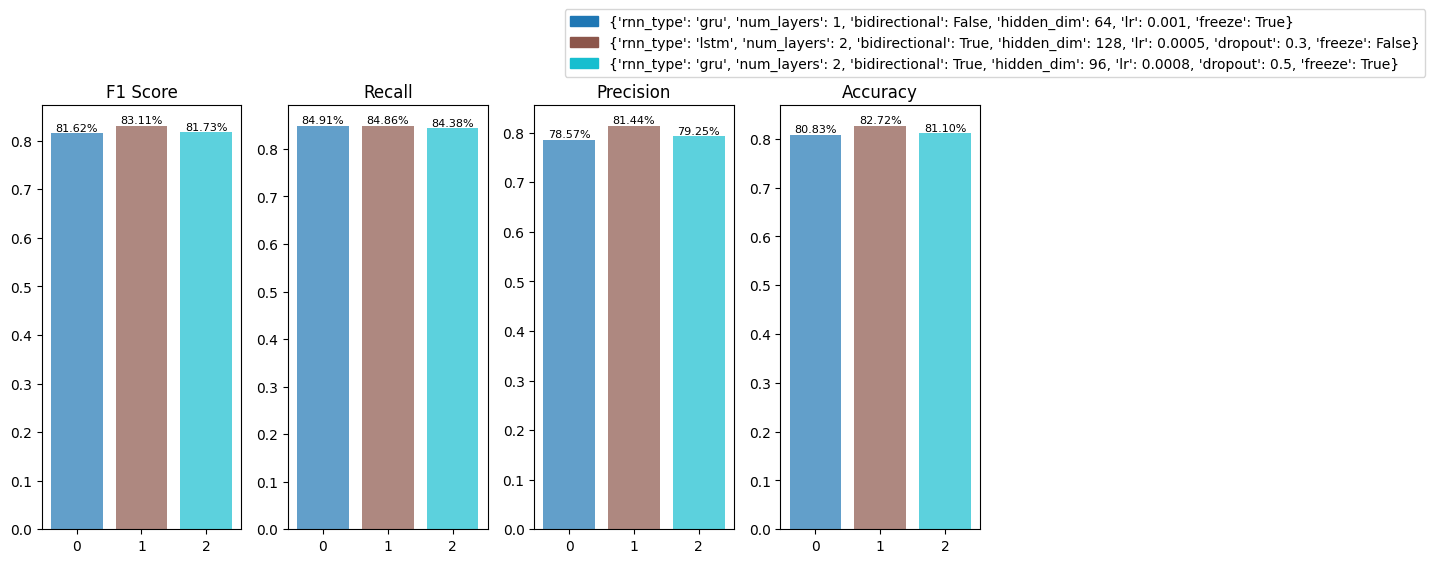

In [95]:
fig, axs = plt.subplots(1, 4, figsize=(10,5 ))

configs = df_results['config']
num_configs = len(configs)
colors = cm.get_cmap('tab10', num_configs)(np.arange(num_configs))

axs[0].bar(df_results.index, df_results['f1'], alpha=0.7, color=colors)
axs[0].set_title('F1 Score')
#axs[0].set_xticklabels(df_results['config'], rotation=45, ha='right')
for p in axs[0].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()

    axs[0].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)

axs[1].bar(df_results.index, df_results['recall'], alpha=0.7,color=colors)
axs[1].set_title('Recall')
#axs[1].set_xticklabels(df_results['config'], rotation=45, ha='right')
for p in axs[1].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axs[1].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)

axs[2].bar(df_results.index, df_results['precision'], alpha=0.7,color=colors)
axs[2].set_title('Precision')
#axs[2].set_xticklabels(df_results['config'], rotation=45, ha='right')
for p in axs[2].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axs[2].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)

axs[3].bar(df_results.index, df_results['accuracy'], alpha=0.7,color=colors)
axs[3].set_title('Accuracy')
#axs[3].set_xticklabels(df_results['config'], rotation=45, ha='right')
for p in axs[3].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axs[3].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)

legend_patches = [
    Patch(color=colors[i], label=configs.iloc[i])
    for i in range(num_configs)
]

fig.legend(handles=legend_patches, loc='center',
           ncol=1, bbox_to_anchor=(1, 1.05))
plt.tight_layout()


plt.show()



# Entrenando el mejor modelo

En esta sección, y dadas las ablaciones anteriores, seleccionamos la mejor combinación modelo - arquitectura,    con los mejores parámetros encontrados en la optimización, para entrenar y mostrar los resultados. Al final del notebook, hemos añadido una aplicación con Gradio que permite correr interactivamente el modelo y hacer el análisis de sentimiento respectivo.

In [100]:
pipeline.model = mejor_modelo

In [101]:
df = imdb_df.copy()

In [102]:
# 1. Asegurarse de tener datos de entrenamiento preprocesados
df_train = pipeline.preprocess_and_tokenize(df, build_vocab=True)
train_dataset = pipeline.create_dataset(df_train)

In [103]:
# 2. Obtener la mejor configuración encontrada previamente
#cfg =pipeline. best_params
cfg = best_params



In [104]:
mejor_modelo

SentimentRNN(
  RNN(hidden_dim=34, bidirectional=True)
  (embedding): Embedding(145675, 100)
  (rnn): LSTM(100, 34, num_layers=2, batch_first=True, dropout=0.11370806346918037, bidirectional=True)
  (dropout): Dropout(p=0.11370806346918037, inplace=False)
  (fc): Linear(in_features=68, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Ya que encontramos el mejor modelo,vamos a entrenarlo por 6 épocas  esto nos debe garantizar un buen desempeño.

In [105]:
# 3. Entrenar el modelo usando esa configuración, pero con 10 épocas
trained_model = pipeline.train(
    train_dataset,
    hidden_dim=best_params['hidden_dim'],
    lr=best_params["lr"],
    freeze=best_params["freeze"],
    epochs=6,  # Número de épocas ajustado
    num_layers=2,
    bidirectional=True,
    rnn_type='lstm',
    batch_size=4
)

Training on device: cuda
Epoch 1 | Loss: 4227.3157 | Accuracy: 0.80
Epoch 2 | Loss: 2244.6225 | Accuracy: 0.91
Epoch 3 | Loss: 1031.9880 | Accuracy: 0.96
Epoch 4 | Loss: 419.5093 | Accuracy: 0.99
Epoch 5 | Loss: 164.1466 | Accuracy: 0.99
Epoch 6 | Loss: 69.2920 | Accuracy: 1.00


Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19815
         1.0       1.00      1.00      1.00     19908

    accuracy                           1.00     39723
   macro avg       1.00      1.00      1.00     39723
weighted avg       1.00      1.00      1.00     39723



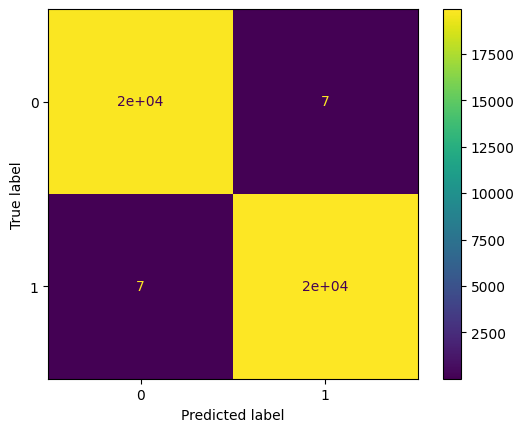

In [106]:
pipeline.evaluate_with_confusion(train_dataset)

# Visualización de la Mejor Arquitectura

Esta librería nos permite visualizar la arquitectura empleada en el entrenamiento del mejor modelo.

In [107]:
!pip install torchview

In [108]:
from torchview import draw_graph
import torch

# Asegúrate de tener el modelo cargado
mejor_modelo = pipeline.model
mejor_modelo_cpu = mejor_modelo.to("cpu").eval()

tensor_auxiliar = torch.randint(0, len(pipeline.vocab), (1, pipeline.max_len))
tensor_auxiliar = tensor_auxiliar.to("cpu")

# Generar visualización del modelo
model_graph = draw_graph(
    mejor_modelo,
    input_data=tensor_auxiliar,
    expand_nested=True,
    save_graph=False,
    filename="SentimentRNN_architecture",
    graph_dir=".",  # carpeta actual,

)



In [111]:
model_graph.visual_graph.render("SentimentRNN_architecture", format="png")

'SentimentRNN_architecture.png'

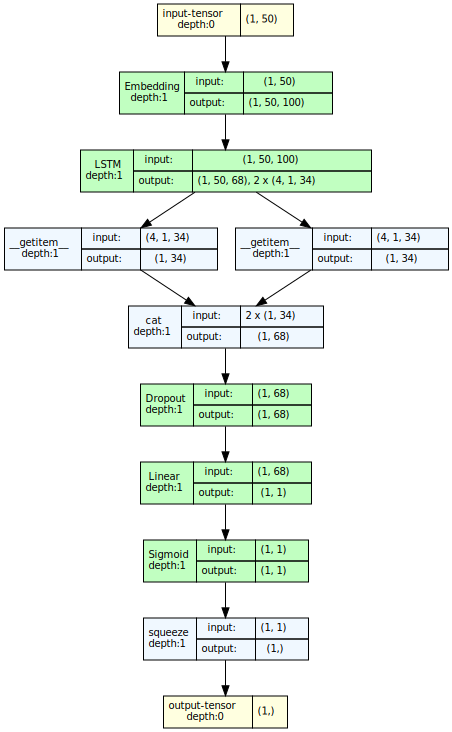

In [112]:
model_graph.visual_graph

In [113]:
model_graph.visual_graph.graph_attr["rankdir"] = "LR"

In [114]:
model_graph.visual_graph.render("/content/drive/MyDrive/MasterIA/DeepLearning/Microproy2/SentimentRNN_LR_architecture", format="png")

'/content/drive/MyDrive/MasterIA/DeepLearning/Microproy2/SentimentRNN_LR_architecture.png'

In [115]:
df_results = pd.DataFrame(summary["results"])
df_results["config_str"] = df_results["config"].apply(
    lambda cfg: f"{cfg['rnn_type']}-{cfg['num_layers']}x{'bi' if cfg['bidirectional'] else 'uni'}"
)

df_results.to_csv("comparacion_modelos.csv", index=False)
print(" Resultados exportados a comparacion_modelos.csv")

 Resultados exportados a comparacion_modelos.csv


In [116]:
!pip freeze > '/content/drive/MyDrive/MasterIA/DeepLearning/Microproy2/requirements.txt'

# Resultados y Conclusiones



1.   **Incidencia de los hiperparámetros**: En la primera parte de este notebook corrimos una optimización de hiperparámetros sobre una arquitectura fija. Pudimos obtener una buen desempeño del modelo, sin embargo esta optimización no nos dio información sobre cómo se comportaba la arquitectura RNN y sus tipos, capas escondidas, bidireccionalidad, etc.
2.   **Incidencia de la Arquitectura**: En cuanto a la información de cada arquitectura, cada ablación que hicimos paso a paso nos mostró que la mejor arquitectura fue en la que usamos RNN tipo GRU, con los siguientes parámetros:


```
{'hidden_dim': 74,
 'lr': 0.0006205974133218978,
 'freeze': False,
 'rnn_type': 'gru',
 'num_layers': 1,
 'bidirectional': True}
```
Vimos que la arquitectura y tipo de la RNN influyen bastante en el rendimiento del modelo época a época, dado que para otras arquitecturas, aunque las métricas fueran similares, el avance de Accuracy empezaba bastante alto para la arquitectura adecuada con los parámetros optimizados.

3.   **Ayuda de Optuna**: La utilización de Optuna en la optimización nos guió en encontrar los mejores hiperparámetros. Partiendo de esta base nos concentramos en la comparación de arquitecturas que nos llevaran al mejor modelo.
4.   **Ventajas y Desventajas de utilizar RNN para Análisis de sentimiento**

**Ventajas**
1. En este modelo, RNN sirvió como una red que puede recordar los tokens utilizados en un texto para comprender el sentimiento del review.
2. Utilizando un modelo pre-entrenado como word2vec se puede alcanzar un buen rendimiento del modelo, al menos en un conjunto de datos pequeño como el de este ejemplo, si se evalúa la arquitectura adecuada.
3. Se necesitan sólo unas pocas capas ocultas para lograr un buen resultado.

**Desventajas**
1. Una RNN unidireccional no capta realmente el sentido de una oración, especialmente si apenas recuerda los tokens anteriores, es probable que dependa de la construcción de las oraciones, por lo tanto puede fallar para ejemplos complejos.

**Resultados**
* La red con mayor rendimiento ha sido una unidireccional. Este es un resultado que no se esperaba, ya que una red bidireccional puede tener mayor contexto en cuanto al sentido de un texto. Es probable  que esto se deba al tamaño del dataset.
* El mejor modelo tuvo un rendimiento bastante alto. Cuando se volvía a correr el notebook el porcentaje del mejor modelo incrementaba, por lo que es posible que hubiéramos llegado a un sobreajuste. Hemos dejado este punto fuera del alcance de este proyecto.




# Creando una aplicación con Gradio para Análisis de Sentimiento para Reviews de Películas

In [117]:
!pip install gradio

In [118]:
import gradio

In [119]:
gradio.Interface(fn=pipeline.predict, inputs="text", outputs="text").launch(debug=True,share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://14341a71bbab3d5203.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Predicting on device: cuda
Predicting on device: cuda
Predicting on device: cuda
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://14341a71bbab3d5203.gradio.live
